In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from copy import copy

In [2]:
from Games import *
import Utility
from os import listdir, mkdir
from os.path import join, isdir
from json import load
from glob import glob

In [3]:
FIGURE = 'figure'
if not isdir(FIGURE):
    mkdir(FIGURE)

In [4]:
PALETTE = {
    "Policy": "red", 
    "Q": "blue", 
    "Random": "orange", 
    "Greedy": "green",
}

In [5]:
def heatmap(dataframe, graph, bounds, player_name, reward_type, info):
    # heat map is only built for both reward
    max_x, max_y = bounds
    max_val = 0
    heatmap_data = {}
    
    if player_name == None:
        p_df = dataframe[dataframe['Reward Type'] == reward_type]
    else:
        p_df = dataframe[dataframe['Agent'] == player_name]
        p_df = p_df[p_df['Reward Type'] == reward_type]
    
    # This block of code finds the number of elites per grid cell. We
    # use this to average the heatmap
    counter = {}
    for node in graph.nodes:
        if '__' in node:
            continue

        a,b,_ = node.split(',')
        key = (int(b), int(a))
        if key in counter:
            counter[key] += 1
        else:
            counter[key] = 1
    
    # build entry in heatmap data 
    for name, d_df in p_df.groupby('Director'):
        data = np.zeros((max_y+1, max_x+1))
        mask = np.ones((max_y+1, max_x+1))
        
        # build the mask
        for n in graph.nodes:
            if '__' in n:
                continue

            a,b,_ = n.split(',')
            mask[int(b)][int(a)] = 0.0
            
        # build heatmap occurrences for each node
        for i, row in d_df.iterrows():
            for n in row.Nodes:
                if '__' in n:
                    continue

                a, b, _ = n.split(',')
                data[int(b)][int(a)] += 1.0
                
        # average the heatmap for the number of runs and cells
        for (y,x), count in counter.items():
            data[y][x] /= info['runs']*count
            max_val = max(data[y][x], max_val) 
        
        # store heatmap data
        heatmap_data[name] = (data, mask)
    
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,4))
    cbar_ax = fig.add_axes([.92, .1, .02, .77])
    
    ordered_directors = list(heatmap_data.keys())
    ordered_directors.sort()
    
    cmap = copy(plt.get_cmap('vlag'))
    cmap.set_under('gray')

    for i, director in enumerate(ordered_directors):
        data, mask = heatmap_data[director]
        ax = sns.heatmap(
            data, 
            mask=mask,
            square=True,
            cmap=cmap,
            ax=axes[i],
            cbar_ax=None if i != 3 else cbar_ax,
            cbar=i==3,
            vmin=0.01,
            vmax=max_val
        )
        
        axes[i].invert_yaxis()
#         axes[i].set_title(f'{director}', y=-0.1)
        axes[i].set_title(director)
        axes[i].set_facecolor("black")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_aspect('auto')
        
        if i == 0:
            axes[i].set_ylabel('Leniency', fontsize=14)
    
    if player_name ==None:
        fig.suptitle(f'Switching Players Graph', fontsize=16, y=0.99)
        
    else:
        if 'Likes High A' in player_name:
            player_name = player_name.replace('High A', 'High Density')
        elif 'Likes High B' in player_name:
            player_name = player_name.replace('High B', 'High Leniency')
        
        fig.suptitle(f'{player_name} for {reward_type} Reward', fontsize=16, y=0.99)
    fig.text(0.5, 0.02, 'Density', ha='center', size=14)
#     plt.show()
    plt.savefig(f'figure/segment_heatmap_{player_name}_{reward_type}.pdf') 

In [40]:
def heatmap_no_greedy(dataframe, graph, bounds, player_name, reward_type, info):
    # heat map is only built for both reward
    max_x, max_y = bounds
    max_val = 0
    heatmap_data = {}
    
    if player_name == None:
        p_df = dataframe[dataframe['Reward Type'] == reward_type]
    else:
        p_df = dataframe[dataframe['Agent'] == player_name]
        p_df = p_df[p_df['Reward Type'] == reward_type]
    
    # This block of code finds the number of elites per grid cell. We
    # use this to average the heatmap
    counter = {}
    for node in graph.nodes:
        if '__' in node:
            continue

        a,b,_ = node.split(',')
        key = (int(b), int(a))
        if key in counter:
            counter[key] += 1
        else:
            counter[key] = 1
    
    # build entry in heatmap data 
    for name, d_df in p_df.groupby('Director'):
        if name == 'Greedy':
            continue
            
        data = np.zeros((max_y+1, max_x+1))
        mask = np.ones((max_y+1, max_x+1))
        
        # build the mask
        for n in graph.nodes:
            if '__' in n:
                continue

            a,b,_ = n.split(',')
            mask[int(b)][int(a)] = 0.0
            
        # build heatmap occurrences for each node
        for i, row in d_df.iterrows():
            for n in row.Nodes:
                if '__' in n:
                    continue

                a, b, _ = n.split(',')
                data[int(b)][int(a)] += 1.0
                
        # average the heatmap for the number of runs and cells
        for (y,x), count in counter.items():
            data[y][x] /= info['runs']*count
            max_val = max(data[y][x], max_val) 
        
        # store heatmap data
        heatmap_data[name] = (data, mask)
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20,4))
    cbar_ax = fig.add_axes([.92, .1, .02, .77])
    
    ordered_directors = list(heatmap_data.keys())
    ordered_directors.sort()
    
    cmap = copy(plt.get_cmap('Greens_r'))
    cmap.set_under('gray')

    for i, director in enumerate(ordered_directors):
        data, mask = heatmap_data[director]
        ax = sns.heatmap(
            data, 
            mask=mask,
            square=True,
            cmap=cmap,
            ax=axes[i],
            cbar_ax=None if i != 2 else cbar_ax,
            cbar=i==2,
            vmin=0.01,
            vmax=max_val
        )
        
        axes[i].invert_yaxis()
#         axes[i].set_title(f'{director}', y=-0.1)
        axes[i].set_title(director)
        axes[i].set_facecolor("black")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_aspect('auto')
        
        if i == 0:
            axes[i].set_ylabel('Leniency', fontsize=14)
    
    if player_name ==None:
        fig.suptitle(f'Switching Players Graph', fontsize=16, y=0.99)
        
    else:
        if 'Likes High A' in player_name:
            player_name = player_name.replace('High A', 'High Density')
        elif 'Likes High B' in player_name:
            player_name = player_name.replace('High B', 'High Leniency')
        
        fig.suptitle(f'{player_name} for {reward_type} Reward', fontsize=16, y=0.99)
    fig.text(0.5, 0.02, 'Density', ha='center', size=14)
#     plt.show()
    plt.savefig(f'figure/segment_heatmap_no_greedy_{player_name}_{reward_type}.pdf') 

In [7]:
def switch_heatmap(dataframe, graph, bounds, player_name, reward_type, info):
    # heat map is only built for both reward
    max_x, max_y = bounds
    max_val = 0
    heatmap_data = {}
    
    if player_name == None:
        p_df = dataframe[dataframe['Reward Type'] == reward_type]
    else:
        p_df = dataframe[dataframe['Agent'] == player_name]
        p_df = p_df[p_df['Reward Type'] == reward_type]
    
    # This block of code finds the number of elites per grid cell. We
    # use this to average the heatmap
    counter = {}
    for node in graph.nodes:
        if '__' in node:
            continue

        a,b,_ = node.split(',')
        key = (int(b), int(a))
        if key in counter:
            counter[key] += 1
        else:
            counter[key] = 1
    
    # build entry in heatmap data 
    for name, d_df in p_df.groupby('Director'):
        min_level = 0
        heatmap_data[name] = [None, None]
        for index, percentage in enumerate([0.7, 0.3]):
            data = np.zeros((max_y+1, max_x+1))
            mask = np.ones((max_y+1, max_x+1))
            
            # filter for the correct split in levels
            old_min_level = min_level
            min_level += int((df.Level.max()+1)*percentage)
            r_df = d_df[d_df.Level.between(old_min_level-1, min_level)]
            
            # build the mask
            for n in graph.nodes:
                if '__' in n:
                    continue

                a,b,_ = n.split(',')
                mask[int(b)][int(a)] = 0.0

            # build heatmap occurrences for each node
            for i, row in r_df.iterrows():
                for n in row.Nodes:
                    if '__' in n:
                        continue

                    a, b, _ = n.split(',')
                    data[int(b)][int(a)] += 1.0

            # average the heatmap for the number of runs and cells
            for (y,x), count in counter.items():
                data[y][x] /= info['runs']*count
                max_val = max(data[y][x], max_val) 

            # store heatmap data
            heatmap_data[name][index] = (data, mask)
    
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,8))
    cbar_ax = fig.add_axes([.92, .1, .02, .77])
    
    ordered_directors = list(heatmap_data.keys())
    ordered_directors.sort()
    
    cmap = copy(plt.get_cmap('vlag'))
    cmap.set_under('gray')

    for i, director in enumerate(ordered_directors):
        for j in range(2):
            data, mask = heatmap_data[director][j]
            ax = sns.heatmap(
                data, 
                mask=mask,
                square=True,
                cmap=cmap,
                ax=axes[j,i],
                cbar_ax=None if i != 3 else cbar_ax,
                cbar=i==3,
                vmin=0.01,
                vmax=max_val
            )

            axes[j,i].invert_yaxis()
    #         axes[i].set_title(f'{director}', y=-0.1)
            axes[j,i].set_title(director)
            axes[j,i].set_facecolor("black")
            axes[j,i].set_xticks([])
            axes[j,i].set_yticks([])
            axes[j,i].set_aspect('auto')

            if i == 0:
                axes[j,i].set_ylabel('Leniency', fontsize=14)
    
    if player_name ==None:
        fig.suptitle(f'Switching From Mediocre Player to Bad Player with {reward_type} Reward', fontsize=16, y=0.99)
    else:
        if 'Likes High A' in player_name:
            player_name = player_name.replace('High A', 'High Density')
        elif 'Likes High B' in player_name:
            player_name = player_name.replace('High B', 'High Leniency')
        
        fig.suptitle(f'{player_name} for {reward_type} Reward', fontsize=16, y=0.99)
        
    def convert(name):
        if 'Likes High A' in name:
            return name.replace('High A', 'High Density')
        elif 'Likes High B' in name:
            return name.replace('High B', 'High Leniency')
        return name
        
    fig.text(0.5, 0.02, 'Density', ha='center', size=14)
    fig.text(0.099, 0.55, convert(info['players'][0]), rotation=90, ha='center', size=14)
    fig.text(0.099, 0.11, convert(info['players'][1]), rotation=90, ha='center', size=14)
#     plt.show()
    plt.savefig('figure/switch_heatmap.pdf')     

In [8]:
def get_all_player_playthroughs(config, start):
    d = []
    info = None
    
    for path in glob(join(config.BASE_DIR, f'{start}*reward_*.json')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-3]
        reward = path_split[-1].split('.')[0]
        
        with open(path, 'r') as f:
            temp = load(f)
            data = temp['data']
            info = temp['info']
        
        for i_session, session in enumerate(data):
            for i_run, run in enumerate(session):
                nodes = []
                sum_percent_complete = 0
                sum_percent_design = 0
                sum_percent_player = 0
                sum_percent_total = 0
                
                for entry in run['Playthrough']:
                    nodes.append(entry['node_name'])
                    
                    sum_percent_complete += entry['Percent Completable']
                    sum_percent_design += entry['Designer Reward']
                    sum_percent_player += entry['Agent Reward']
                    sum_percent_total += entry['Total Reward']
                    
#                 d.append((
#                     reward, 
#                     player, 
#                     director,
#                     i_run,
#                     sum_percent_complete,
#                     sum_percent_design,
#                     sum_percent_player,
#                     sum_percent_total,
#                     nodes
#                 ))
                    
                d.append((
                    reward, 
                    player, 
                    director,
                    i_run,
                    run['percent_complete'],
                    run['percent_design_reward'],
                    run['percent_player_reward'],
                    run['percent_total_reward'],
                    run['percent_reward'],
                    nodes
                ))
    
    labels = (
        'Reward Type', 
        'Agent', 
        'Director',
        'Level',
        'Percent Complete', 
        'Design Reward', 
        'Player Reward', 
        'Total Reward',
        'Reward',
        'Nodes'
    )
    return pd.DataFrame(d, columns=labels), info

In [9]:
def plot_player_personas_over_time(df):
    # sort keys so the output is always in the same order
    player_names = list(df.Agent.unique())
    player_names.sort()
    
    reward_names = ['DESIGNER', 'PLAYER', 'BOTH', 'Percent Complete']
    
    # build plots and set title
    fig, axes = plt.subplots(4, len(player_names), sharex=True, sharey=True, figsize=(20,12))
    fig.suptitle(f'Average Reward Per Level for Icarus', fontsize=16)
    
    # fill in each plot
    for y, name in enumerate(reward_names):
        for x, player in enumerate(player_names):
            if name == 'Percent Complete':
                g_df = df[df['Reward Type'] == 'BOTH']
            else:
                g_df = df[df['Reward Type'] == name]
                
            g_df = g_df[g_df['Agent'] == player]
            
            if name == 'Percent Complete':
                ax = sns.lineplot(ax=axes[y, x], data=g_df, x='Level', y='Percent Complete', hue='Director', palette=PALETTE)
            else:
                ax = sns.lineplot(ax=axes[y, x], data=g_df, x='Level', y='Reward', hue='Director', palette=PALETTE)
            ax.get_legend().remove()
            ax.set_xlabel('')
            ax.set_ylabel(REWARD_MAP[name])
            
            if y == 0:
                if 'Likes High A' in player:
                    player = player.replace('High A', 'High Density')
                elif 'Likes High B' in player:
                    player = player.replace('High B', 'High Leniency')
                    
                ax.set_title('Likes\n'.join(player.split('Likes')), fontsize=12)
                
            if x == 0:
                ax.set_ylabel(name, fontsize=14)
            else:
                ax.set_ylabel('')
                
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.905, 0.99))
    fig.text(0.5, 0.08, 'Level', ha='center', size=14)
#     fig.text(0.08, 0.5, 'Reward', va='center', rotation='vertical', size=14)
#     plt.show()
    plt.savefig('figure/icarus_segments_graph.pdf')     

# Icarus Level Segments

In [67]:
config = Icarus
graph = Utility.get_level_segment_graph(config, True)

REWARD_MAP = {
    'DESIGNER': 'Design Reward',
    'PLAYER': 'Player Reward',
    'BOTH': 'Total Reward',
    'Percent Complete': 'Percent Complete',
}

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
df, info = get_all_player_playthroughs(config, 'player')

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


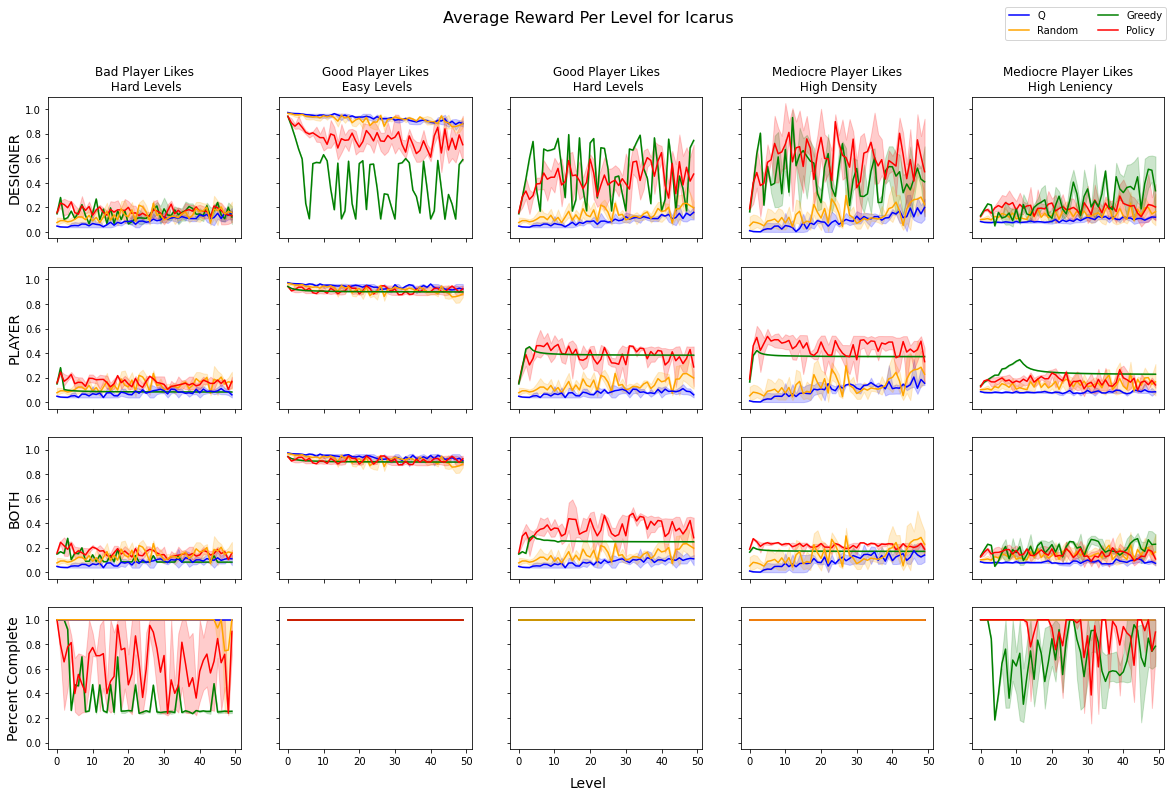

In [68]:
plot_player_personas_over_time(df)

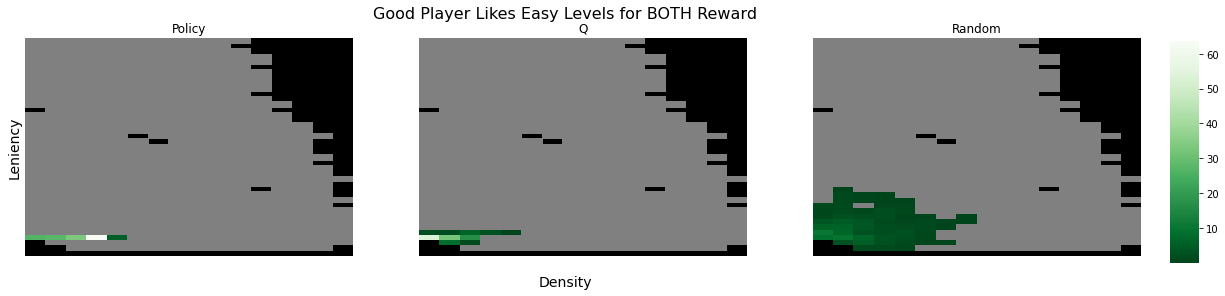

In [69]:
heatmap_no_greedy(df, graph, config.MAX_BC, 'Good Player Likes Easy Levels', 'BOTH', info) 

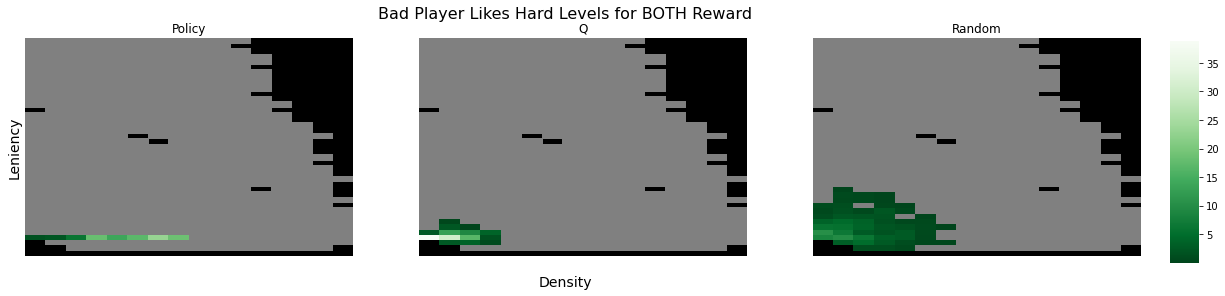

In [70]:
heatmap_no_greedy(df, graph, config.MAX_BC, 'Bad Player Likes Hard Levels', 'BOTH', info) 

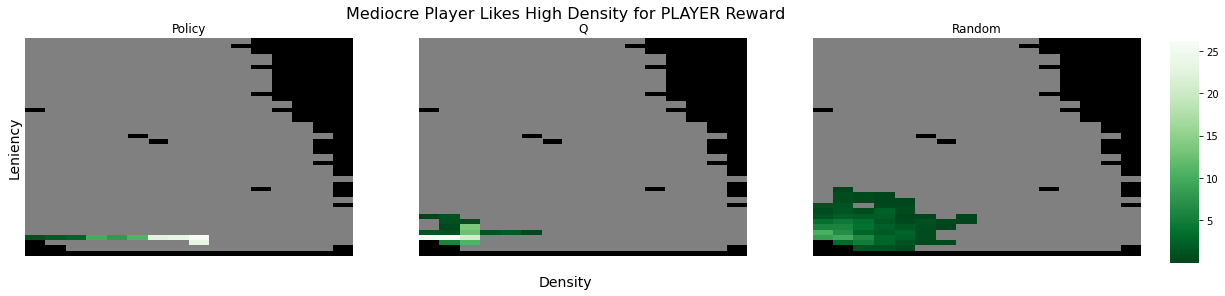

In [71]:
heatmap_no_greedy(df, graph, config.MAX_BC, 'Mediocre Player Likes High A', 'PLAYER', info) 

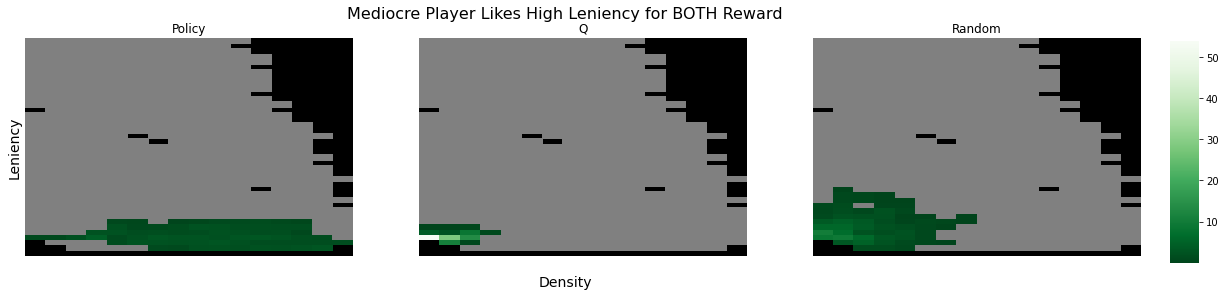

In [72]:
heatmap_no_greedy(df, graph, config.MAX_BC, 'Mediocre Player Likes High B', 'BOTH', info) 

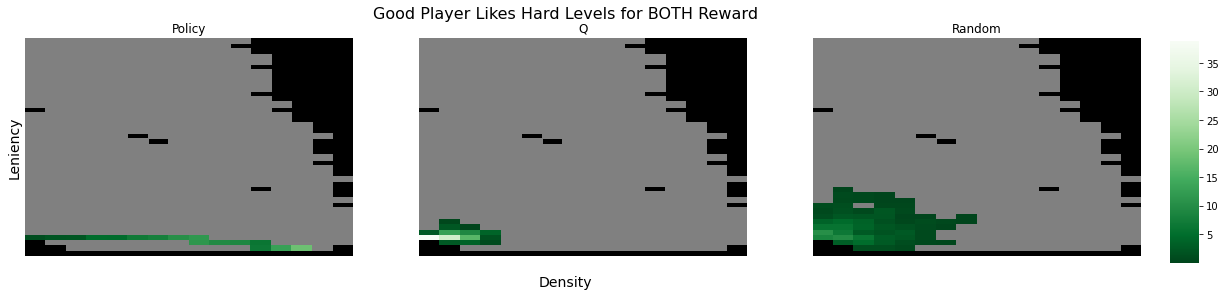

In [73]:
heatmap_no_greedy(df, graph, config.MAX_BC, 'Good Player Likes Hard Levels', 'BOTH', info) 

# Switching Players

In [17]:
config = Icarus
graph = Utility.get_level_segment_graph(config, True)

rewards = ('Design Reward', 'Player Reward', 'Both Reward')

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.BOTH)
df, info = get_all_player_playthroughs(config, 'switch')

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


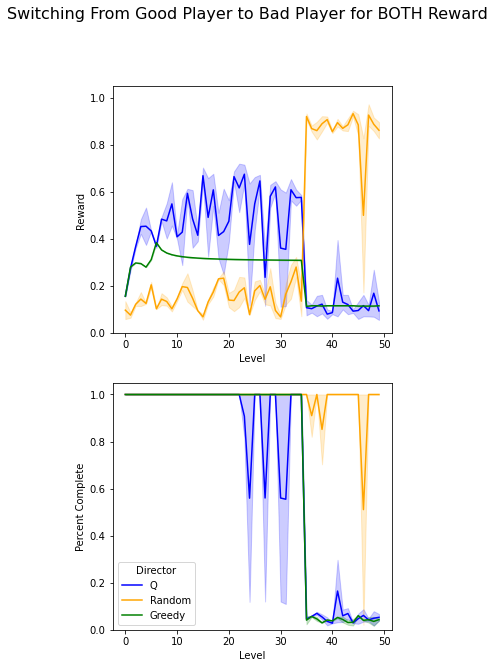

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(5,10))

fig.suptitle(f'Switching From Good Player to Bad Player for BOTH Reward', fontsize=16, y=0.99)
ax = sns.lineplot(ax=axes[0], data=df, x='Level', y='Reward', hue='Director', palette=PALETTE)
ax.set(ylim=(0, 1.05))
axes[0].set_ylabel('Reward')
axes[0].get_legend().remove()

ax = sns.lineplot(ax=axes[1], data=df, x='Level', y='Percent Complete', hue='Director', palette=PALETTE)
ax.set(ylim=(0, 1.05))

plt.savefig('figure/switching_players_reward.pdf', bbox_inches='tight')  

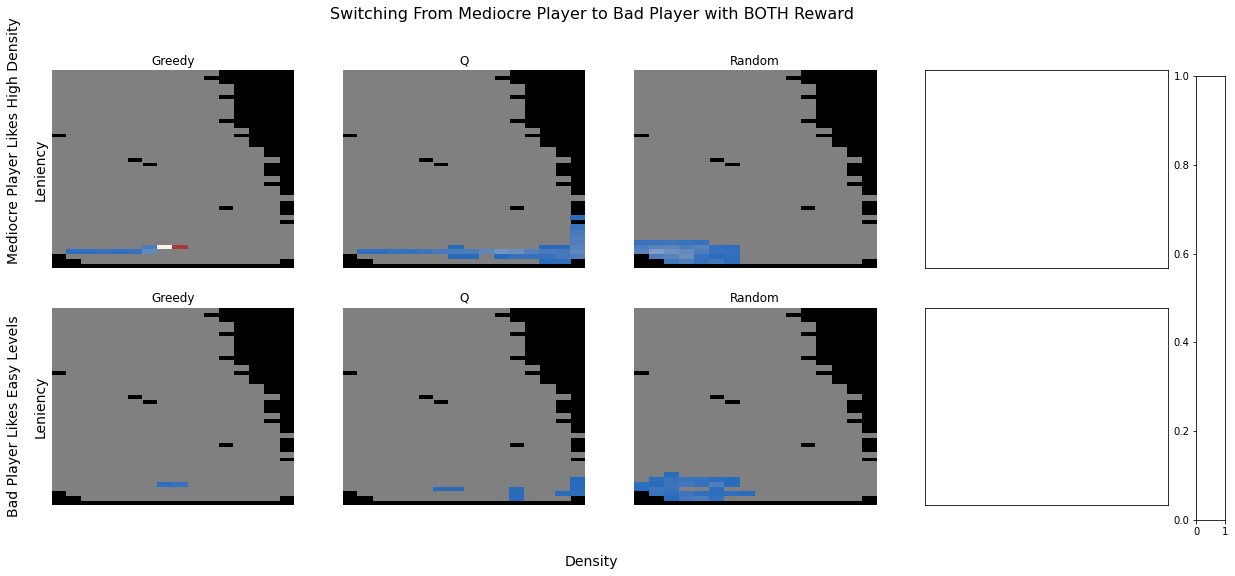

In [19]:
switch_heatmap(df, graph, config.MAX_BC, None, 'BOTH', info)

In [20]:
df.groupby(['Director']).mean('Reward')

,Level,Percent Complete,Design Reward,Player Reward,Total Reward,Reward
Director,,,,,,
Greedy,24.5,0.712700,0.015661,0.237663,0.253324,0.253324
Q,24.5,0.680179,0.057383,0.316656,0.374039,0.374039
Random,24.5,0.985446,0.034043,0.331452,0.365495,0.365495


In [21]:
df

,Reward Type,Agent,Director,Level,Percent Complete,Design Reward,Player Reward,Total Reward,Reward,Nodes
0,BOTH,game,Q,0,1.000000,0.048958,0.108333,0.157292,0.157292,"[1,3,0, 2,3,0, 2,3,0__3,3,0, 3,3,0]"
1,BOTH,game,Q,1,1.000000,0.086458,0.200000,0.286458,0.286458,"[4,3,0, 4,3,0__5,3,0, 5,3,0, 6,3,0]"
2,BOTH,game,Q,2,1.000000,0.101562,0.275000,0.376562,0.376562,"[6,3,0, 7,3,0, 7,3,0__8,3,0, 8,3,0]"
3,BOTH,game,Q,3,1.000000,0.093519,0.329167,0.422685,0.422685,"[7,3,0__8,3,0, 8,3,0, 8,3,0__9,3,0, 9,3,0, 9,3..."
4,BOTH,game,Q,4,1.000000,0.142708,0.391667,0.534375,0.534375,"[9,3,0__10,3,0, 10,3,0, 11,3,0, 12,3,0]"
...,...,...,...,...,...,...,...,...,...,...
295,BOTH,game,Greedy,45,0.058455,0.000412,0.113889,0.114301,0.114301,"[8,4,1__8,4,0]"
296,BOTH,game,Greedy,46,0.038305,0.000400,0.113889,0.114289,0.114289,"[8,4,1__8,4,0]"
297,BOTH,game,Greedy,47,0.054781,0.000388,0.113889,0.114277,0.114277,"[8,4,1__8,4,0]"
298,BOTH,game,Greedy,48,0.016772,0.000377,0.113889,0.114266,0.114266,"[8,4,1__8,4,0]"


# N-Gram

In [22]:
config = Mario
graph = Utility.get_level_segment_graph(config, True)

rewards = ('Design Reward', 'Player Reward', 'Both Reward')

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
df, info = get_all_player_playthroughs(config, 'player')

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


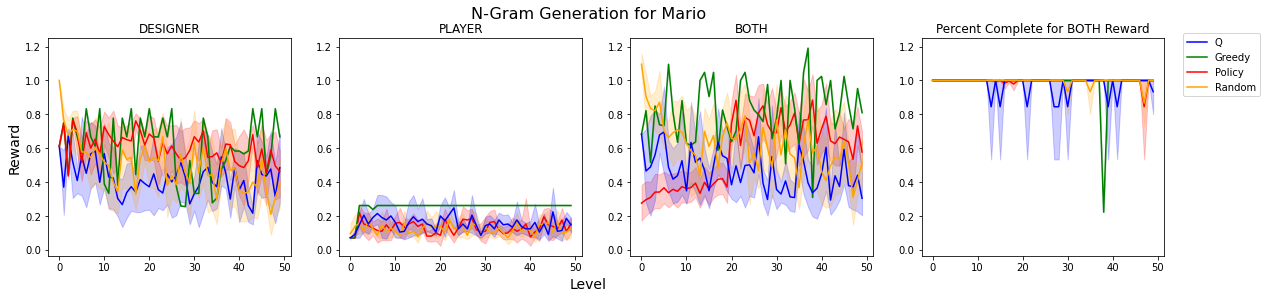

In [23]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,4))
    
for i, rt in enumerate(['DESIGNER', 'PLAYER', 'BOTH']):
    g_df = df[df['Reward Type'] == rt]
    ax = sns.lineplot(ax=axes[i], data=g_df, x='Level', y=REWARD_MAP[rt], hue='Director', palette=PALETTE)
    axes[i].set_title(rt)
    axes[i].set_ylabel('Reward',fontsize=14)
    axes[i].set_xlabel('')
    axes[i].get_legend().remove()
#     axes[i].tick_params(axis='both', which='both')
    axes[i].yaxis.set_tick_params(labelbottom=True)
    
    
g_df = df[df['Reward Type'] == 'BOTH']
ax = sns.lineplot(ax=axes[3], data=g_df, x='Level', y='Percent Complete', hue='Director', palette=PALETTE)
axes[3].set_title('Percent Complete for BOTH Reward')
axes[3].set_ylabel('Percent Complete',fontsize=14)
axes[3].set_xlabel('')
axes[3].get_legend().remove()
axes[3].yaxis.set_tick_params(labelbottom=True)

    
handles, labels = axes[0].get_legend_handles_labels()   
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(.97, 0.915))
fig.text(0.5, 0.01, 'Level', ha='center', size=14)
fig.suptitle(f'N-Gram Generation for Mario', fontsize=16,  y=0.99)
# plt.show()
plt.savefig('figure/n_gram_mario.pdf') 

[]

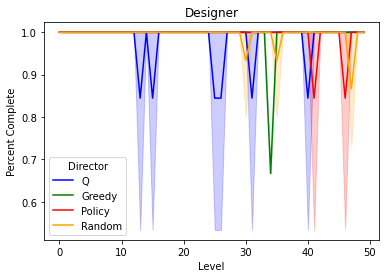

In [24]:
g_df = df[df['Reward Type'] == 'DESIGNER']
ax = sns.lineplot(data=g_df, x='Level', y='Percent Complete', hue='Director', palette=PALETTE)
plt.title('Designer')
plt.plot()

[]

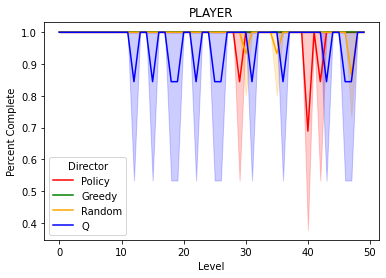

In [25]:
g_df = df[df['Reward Type'] == 'PLAYER']
ax = sns.lineplot(data=g_df, x='Level', y='Percent Complete', hue='Director', palette=PALETTE)
plt.title('PLAYER')
plt.plot()

In [26]:
df.groupby(['Reward Type', 'Agent', 'Director']).mean('Percent Complete')

Level  Percent Complete  \
Reward Type Agent                         Director                            
BOTH        Bad Player Likes Hard Levels  Policy      9.5          0.987606   
            Good Player Likes Easy Levels Policy      9.5          1.000000   
            Good Player Likes Hard Levels Policy      9.5          1.000000   
            Mediocre Player Likes High A  Policy      9.5          1.000000   
            Mediocre Player Likes High B  Policy      9.5          1.000000   
            agent                         Greedy     24.5          0.984444   
                                          Policy     24.5          0.996889   
                                          Q          24.5          0.973778   
                                          Random     24.5          0.994667   
DESIGNER    agent                         Greedy     24.5          0.993333   
                                          Policy     24.5          0.993778   
                                          Q          24.5          0.981333   
                                          Random     24.5          0.994667   
PLAYER      agent                         Greedy     24.5          1.000000   
                                          Policy     24.5          0.987556   
                                          Q          24.5          0.962667   
                                          Random     24.5          0.994667   

                                                    Design Reward  \
Reward Type Agent                         Director                  
BOTH        Bad Player Likes Hard Levels  Policy         0.047450   
            Good Player Likes Easy Levels Policy         0.003465   
            Good Player Likes Hard Levels Policy         0.048855   
            Mediocre Player Likes High A  Policy         0.078563   
            Mediocre Player Likes High B  Policy         0.018311   
            agent                         Greedy         0.673860   
                                          Policy         0.579157   
                                          Q              0.322185   
                                          Random         0.500373   
DESIGNER    agent                         Greedy         0.602577   
                                          Policy         0.602283   
                                          Q              0.422632   
                                          Random         0.500373   
PLAYER      agent                         Greedy         0.137167   
                                          Policy         0.657098   
                                          Q              0.507454   
                                          Random         0.500373   

                                                    Player Reward  \
Reward Type Agent                         Director                  
BOTH        Bad Player Likes Hard Levels  Policy         0.108732   
            Good Player Likes Easy Levels Policy         0.983623   
            Good Player Likes Hard Levels Policy         0.110906   
            Mediocre Player Likes High A  Policy         0.038478   
            Mediocre Player Likes High B  Policy         0.140942   
            agent                         Greedy         0.148571   
                                          Policy         0.162190   
                                          Q              0.145048   
                                          Random         0.122857   
DESIGNER    agent                         Greedy         0.136190   
                                          Policy         0.146762   
                                          Q              0.141333   
                                          Random         0.122857   
PLAYER      agent                         Greedy         0.253810   
                                          Policy         0.131714   
                                          Q              0.153238

In [27]:
info['runs']

5

In [28]:
for (rt, a, d), temp_df in df.groupby(['Reward Type', 'Agent', 'Director']):
    counter = {}
    for lvl_nodes in temp_df.Nodes:
        for n in lvl_nodes:
            if n in counter:
                counter[n] += 1
            else:
                counter[n] = 1
    
    total = 0
    for k in counter:
        total += counter[k]
        
    print(rt,a,d, total/len(graph.nodes))

BOTH Bad Player Likes Hard Levels Policy 0.23047177107501934
BOTH Good Player Likes Easy Levels Policy 0.23201856148491878
BOTH Good Player Likes Hard Levels Policy 0.23201856148491878
BOTH Mediocre Player Likes High A Policy 0.23201856148491878
BOTH Mediocre Player Likes High B Policy 0.23201856148491878
BOTH agent Greedy 0.2861562258313998
BOTH agent Policy 0.28924980665119876
BOTH agent Q 0.2834493426140758
BOTH agent Random 0.288476411446249
DESIGNER agent Greedy 0.2880897138437742
DESIGNER agent Policy 0.288476411446249
DESIGNER agent Q 0.2853828306264501
DESIGNER agent Random 0.288476411446249
PLAYER agent Greedy 0.2900232018561485
PLAYER agent Policy 0.28692962103634956
PLAYER agent Q 0.28074245939675174
PLAYER agent Random 0.288476411446249
